<a href="https://colab.research.google.com/github/pateltanvi2992/In-Doamin-GAN/blob/main/In_Domain_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

os.chdir('/content')
CODE_DIR = 'idinvert'
if not os.path.exists(CODE_DIR):
  !git clone https://github.com/genforce/idinvert_pytorch.git $CODE_DIR
os.chdir(f'./{CODE_DIR}')
MODEL_DIR = os.path.join('models', 'pretrain')
os.makedirs(MODEL_DIR, exist_ok=True)
!wget https://mycuhk-my.sharepoint.com/:u:/g/personal/1155082926_link_cuhk_edu_hk/EXqix_JIEgtLl1FXI4uCkr8B5GPaiJyiLXL6cFbdcIKqEA?e=WYesel\&download\=1 -O $MODEL_DIR/styleganinv_ffhq256_encoder.pth  --quiet
!wget https://mycuhk-my.sharepoint.com/:u:/g/personal/1155082926_link_cuhk_edu_hk/EbuzMQ3ZLl1AqvKJzeeBq7IBoQD-C1LfMIC8USlmOMPt3Q?e=CMXn8W\&download\=1 -O $MODEL_DIR/styleganinv_ffhq256_generator.pth  --quiet
!wget https://mycuhk-my.sharepoint.com/:u:/g/personal/1155082926_link_cuhk_edu_hk/EQJUz9DInbxEnp0aomkGGzAB5b3ZZbtsOA-TXct9E4ONqA?e=smtO0T\&download\=1 -O $MODEL_DIR/vgg16.pth  --quiet
!nvidia-smi

Cloning into 'idinvert'...
remote: Enumerating objects: 89, done.
remote: Total 89 (delta 0), reused 0 (delta 0), pack-reused 89
Unpacking objects: 100% (89/89), done.
Thu Jul 14 18:44:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |


In [2]:
# python 3.6
"""Demo."""
import os
import sys
import io
import bz2
import requests
import dlib
import numpy as np
from PIL import Image
import IPython.display
import scipy.ndimage
from google.colab import files
from google.colab import output
from utils.editor import manipulate
from utils.inverter import StyleGANInverter
from models.helper import build_generator


LANDMARK_MODEL_NAME = 'shape_predictor_68_face_landmarks.dat'
LANDMARK_MODEL_PATH = os.path.join(MODEL_DIR, LANDMARK_MODEL_NAME)
LANDMARK_MODEL_URL = f'http://dlib.net/files/{LANDMARK_MODEL_NAME}.bz2'
model_name = 'styleganinv_ffhq256'
pre = 'examples'
inverted_code_dir = 'inverted_codes'
os.makedirs(inverted_code_dir, exist_ok=True)

class FaceLandmarkDetector(object):
  """Class of face landmark detector."""

  def __init__(self, align_size=256, enable_padding=True):
    """Initializes face detector and landmark detector.

  Args:
    align_size: Size of the aligned face if performing face alignment.
    (default: 1024)
    enable_padding: Whether to enable padding for face alignment (default:
    True)
  """
    # Download models if needed.
    if not os.path.exists(LANDMARK_MODEL_PATH):
      data = requests.get(LANDMARK_MODEL_URL)
      data_decompressed = bz2.decompress(data.content)
      with open(LANDMARK_MODEL_PATH, 'wb') as f:
        f.write(data_decompressed)

    self.face_detector = dlib.get_frontal_face_detector()
    self.landmark_detector = dlib.shape_predictor(LANDMARK_MODEL_PATH)
    self.align_size = align_size
    self.enable_padding = enable_padding

  def detect(self, image_path):
    """Detects landmarks from the given image.

  This function will first perform face detection on the input image. All
  detected results will be grouped into a list. If no face is detected, an
  empty list will be returned.

  For each element in the list, it is a dictionary consisting of `image_path`,
  `bbox` and `landmarks`. `image_path` is the path to the input image. `bbox`
  is the 4-element bounding box with order (left, top, right, bottom), and
  `landmarks` is a list of 68 (x, y) points.

  Args:
    image_path: Path to the image to detect landmarks from.

  Returns:
    A list of dictionaries, each of which is the detection results of a
    particular face.
  """
    results = []

    # image_ = np.array(image)
    images = dlib.load_rgb_image(image_path)
    # Face detection (1 means to upsample the image for 1 time.)
    bboxes = self.face_detector(images, 1)
    # Landmark detection
    for bbox in bboxes:
      landmarks = []
      for point in self.landmark_detector(images, bbox).parts():
        landmarks.append((point.x, point.y))
      results.append({
          'image_path': image_path,
          'bbox': (bbox.left(), bbox.top(), bbox.right(), bbox.bottom()),
          'landmarks': landmarks,
      })
    return results

  def align(self, face_info):
    """Aligns face based on landmark detection.

  The face alignment process is borrowed from
  https://github.com/NVlabs/ffhq-dataset/blob/master/download_ffhq.py,
  which only supports aligning faces to square size.

  Args:
    face_info: Face information, which is the element of the list returned by
    `self.detect()`.

  Returns:
    A `np.ndarray`, containing the aligned result. It is with `RGB` channel
    order.
  """
    img = Image.open(face_info['image_path'])

    landmarks = np.array(face_info['landmarks'])
    eye_left = np.mean(landmarks[36: 42], axis=0)
    eye_right = np.mean(landmarks[42: 48], axis=0)
    eye_middle = (eye_left + eye_right) / 2
    eye_to_eye = eye_right - eye_left
    mouth_middle = (landmarks[48] + landmarks[54]) / 2
    eye_to_mouth = mouth_middle - eye_middle

    # Choose oriented crop rectangle.
    x = eye_to_eye - np.flipud(eye_to_mouth) * [-1, 1]
    x /= np.hypot(*x)
    x *= max(np.hypot(*eye_to_eye) * 2.0, np.hypot(*eye_to_mouth) * 1.8)
    y = np.flipud(x) * [-1, 1]
    c = eye_middle + eye_to_mouth * 0.1
    quad = np.stack([c - x - y, c - x + y, c + x + y, c + x - y])
    qsize = np.hypot(*x) * 2

    # Shrink.
    shrink = int(np.floor(qsize / self.align_size * 0.5))
    if shrink > 1:
      rsize = (int(np.rint(float(img.size[0]) / shrink)),
               int(np.rint(float(img.size[1]) / shrink)))
      img = img.resize(rsize, Image.ANTIALIAS)
      quad /= shrink
      qsize /= shrink

    # Crop.
    border = max(int(np.rint(qsize * 0.1)), 3)
    crop = (int(np.floor(min(quad[:, 0]))), int(np.floor(min(quad[:, 1]))),
            int(np.ceil(max(quad[:, 0]))), int(np.ceil(max(quad[:, 1]))))
    crop = (max(crop[0] - border, 0),
            max(crop[1] - border, 0),
            min(crop[2] + border, img.size[0]),
            min(crop[3] + border, img.size[1]))
    if crop[2] - crop[0] < img.size[0] or crop[3] - crop[1] < img.size[1]:
      img = img.crop(crop)
      quad -= crop[0:2]

    # Pad.
    pad = (int(np.floor(min(quad[:, 0]))), int(np.floor(min(quad[:, 1]))),
           int(np.ceil(max(quad[:, 0]))), int(np.ceil(max(quad[:, 1]))))
    pad = (max(-pad[0] + border, 0),
           max(-pad[1] + border, 0),
           max(pad[2] - img.size[0] + border, 0),
           max(pad[3] - img.size[1] + border, 0))
    if self.enable_padding and max(pad) > border - 4:
      pad = np.maximum(pad, int(np.rint(qsize * 0.3)))
      img = np.pad(np.float32(img),
                   ((pad[1], pad[3]), (pad[0], pad[2]), (0, 0)),
                   'reflect')
      h, w, _ = img.shape
      y, x, _ = np.ogrid[:h, :w, :1]
      mask = np.maximum(1.0 - np.minimum(np.float32(x) / pad[0],
                                         np.float32(w - 1 - x) / pad[2]),
                        1.0 - np.minimum(np.float32(y) / pad[1],
                                         np.float32(h - 1 - y) / pad[3]))
      blur = qsize * 0.02
      blurred_image = scipy.ndimage.gaussian_filter(img, [blur, blur, 0]) - img
      img += blurred_image * np.clip(mask * 3.0 + 1.0, 0.0, 1.0)
      img += (np.median(img, axis=(0, 1)) - img) * np.clip(mask, 0.0, 1.0)
      img = Image.fromarray(np.uint8(np.clip(np.rint(img), 0, 255)), 'RGB')
      quad += pad[:2]

    # Transform.
    img = img.transform((self.align_size * 4, self.align_size * 4), Image.QUAD,
                        (quad + 0.5).flatten(), Image.BILINEAR)
    img = img.resize((self.align_size, self.align_size), Image.ANTIALIAS)

    return np.array(img)


def align_face(image_path, align_size=256):
  """Aligns a given face."""
  model = FaceLandmarkDetector(align_size)
  face_infos = model.detect(image_path)
  face_infos = face_infos[0]
  img = model.align(face_infos)
  return img


def build_inverter(model_name, iteration=100, regularization_loss_weight=2):
  """Builds inverter"""
  inverter = StyleGANInverter(
      model_name,
      learning_rate=0.01,
      iteration=iteration,
      reconstruction_loss_weight=1.0,
      perceptual_loss_weight=5e-5,
      regularization_loss_weight=regularization_loss_weight)
  return inverter


def get_generator(model_name):
  """Gets model by name"""
  return build_generator(model_name)


def align(inverter, image_path):
  """Aligns an unloaded image."""
  aligned_image = align_face(image_path,
                             align_size=inverter.G.resolution)
  return aligned_image


def invert(inverter, image):
  """Inverts an image."""
  latent_code, reconstruction = inverter.easy_invert(image, num_viz=1)
  return latent_code, reconstruction


def diffuse(inverter, target, context, left, top, width, height):
  """Diffuses a target image to a context image."""
  center_x = left + width // 2
  center_y = top + height // 2
  _, diffusion = inverter.easy_diffuse(target=target,
                                       context=context,
                                       center_x=center_x,
                                       center_y=center_y,
                                       crop_x=width,
                                       crop_y=height,
                                       num_viz=1)
  return diffusion


def load_image(path):
  """Loads an image from disk.

  NOTE: This function will always return an image with `RGB` channel order for
  color image and pixel range [0, 255].

  Args:
    path: Path to load the image from.

  Returns:
    An image with dtype `np.ndarray` or `None` if input `path` does not exist.
  """
  if not os.path.isfile(path):
    return None

  image = Image.open(path)
  return image

def imshow(images, col, viz_size=256):
  """Shows images in one figure."""
  num, height, width, channels = images.shape
  assert num % col == 0
  row = num // col

  fused_image = np.zeros((viz_size * row, viz_size * col, channels), dtype=np.uint8)

  for idx, image in enumerate(images):
    i, j = divmod(idx, col)
    y = i * viz_size
    x = j * viz_size
    if height != viz_size or width != viz_size:
      image = cv2.resize(image, (viz_size, viz_size))
    fused_image[y:y + viz_size, x:x + viz_size] = image

  fused_image = np.asarray(fused_image, dtype=np.uint8)
  data = io.BytesIO()
  if channels == 4:
    Image.fromarray(fused_image).save(data, 'png')
  elif channels == 3:
    Image.fromarray(fused_image).save(data, 'jpeg')
  else:
    raise ValueError('Image channel error')
  im_data = data.getvalue()
  disp = IPython.display.display(IPython.display.Image(im_data))
  return disp


In [3]:
print('Building inverter')
inverter = build_inverter(model_name=model_name)
print('Building generator')
generator = get_generator(model_name)
output.clear()
print('Please upload the image you want to manipulate or \
use the default images by clicking `Cancel upload` button.')
uploaded = files.upload()
if uploaded:
  image_name = list(uploaded.keys())[0]
  mani_image = align(inverter, image_name)
  if mani_image.shape[2] == 4:
    mani_image = mani_image[:, :, :3]
  os.remove(image_name)
else:
  image_name = '000006.png'
  im_name = os.path.join(pre, image_name)
  mani_image = align(inverter, im_name)
print('Image ready, starting inversion!!!')
sys.stdout.flush()

latent_code_path = os.path.join(inverted_code_dir, 
                                image_name.split('.')[0] + '.npy')
if not os.path.exists(latent_code_path):
  latent_code, _ = invert(inverter, mani_image)
  np.save(latent_code_path, latent_code)
else:
  print('code already exists, skip inversion!!!')
  latent_code = np.load(latent_code_path)

ATTRS = ['age', 'eyeglasses', 'gender', 'pose', 'expression']
boundaries = {}
for attr in ATTRS:
  boundary_path = os.path.join('./boundaries', 
                               'stylegan_ffhq256', attr + '.npy')
  boundary_file = np.load(boundary_path, allow_pickle=True)[()]
  boundary = boundary_file['boundary']
  manipulate_layers = boundary_file['meta_data']['manipulate_layers']
  boundaries[attr] = []
  boundaries[attr].append(boundary)
  boundaries[attr].append(manipulate_layers)
print()
print('Image inversion completed, please use the next block to manipulate!!!')

Please upload the image you want to manipulate or use the default images by clicking `Cancel upload` button.


Saving Angelman-1 - Copy.jpg to Angelman-1 - Copy.jpg
Image ready, starting inversion!!!


loss_pix: 0.042, loss_feat: 2460.483, loss_reg: 0.045, loss: 0.254: 100%|██████████| 100/100 [00:08<00:00, 11.47it/s]


Image inversion completed, please use the next block to manipulate!!!


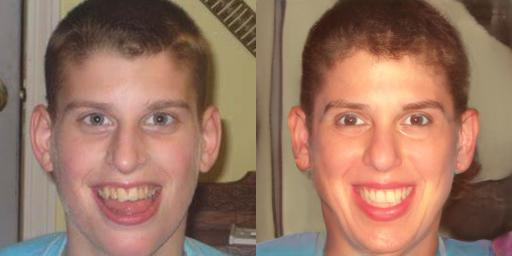

In [8]:
#@title { display-mode: "form", run: "auto" }

#age = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
#eyeglasses = 0 #@param {type:"slider", min:-2.9, max:3.0, step:0.1}
#gender = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
#pose = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
expression = -0.1 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}


new_codes = latent_code.copy()
for i, attr_name in enumerate(ATTRS):
  manipulate_layers = boundaries[attr_name][1]
  new_codes[:, manipulate_layers, :] += boundaries[attr_name][0][:, manipulate_layers, :] * eval(attr_name)

new_images = generator.easy_synthesize(new_codes, **{'latent_space_type': 'wp'})['image']
showed_images = np.concatenate([mani_image[np.newaxis], new_images], axis=0)
imshow(showed_images, col=showed_images.shape[0])